<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3a_OSI_SAF_SST_mapping_Metop_Metagranules.ipynb" target="_blank"><< Mapping Metop SST Metagranules</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3c_OSI_SAF_SST_mapping_MSG_SST.ipynb" target="_blank">Mapping Meteosat SEVIRI SST >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sst/HEAD?urlpath=%2Ftree%2F1_OSI_SAF_sst_introductory%2F1_3b_OSI_SAF_SST_mapping_Global_Metop_SST.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea surface temperature: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb" target="_blank">1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb</a>**

</div>
<hr>

# 1.3b Mapping Global Metop AVHRR SST products

### Data used 

| Product Description | Product Navigator | OSI SAF website link | OSI SAF Identifier |
|:--------------------:|:-------------:|:-----------------:|:-----------------:|
| Global Metop Sea Surface Temperature | EO:EUM:DAT:METOP:GLB-SST-NC | <a href="https://osi-saf.eumetsat.int/products/osi-201-b" target="_blank">link</a>| OSI-201-b | 


### Learning outcomes

At the end of this notebook you will know;
* How to open Global Metop / AVHRR SST files
* Map SST using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>

 1. [Setting parameters](#section1)
 1. [Map SST](#section3)
 
<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import numpy as np                 # a library that supports array manipulation
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting parameters
[Back to top](#TOC_TOP)

</div>

Setting directory where to read data files

In [2]:
directory = 'products/global'

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [3]:
#cmap = mpl_cm.get_cmap('RdYlBu_r')
cmap = cmocean.cm.thermal

<div class="alert alert-danger" role="alert">

## <a id='section2'></a>2. Map SST
[Back to top](#TOC_TOP)

</div>

Mapping figure based on retrieved global SST file

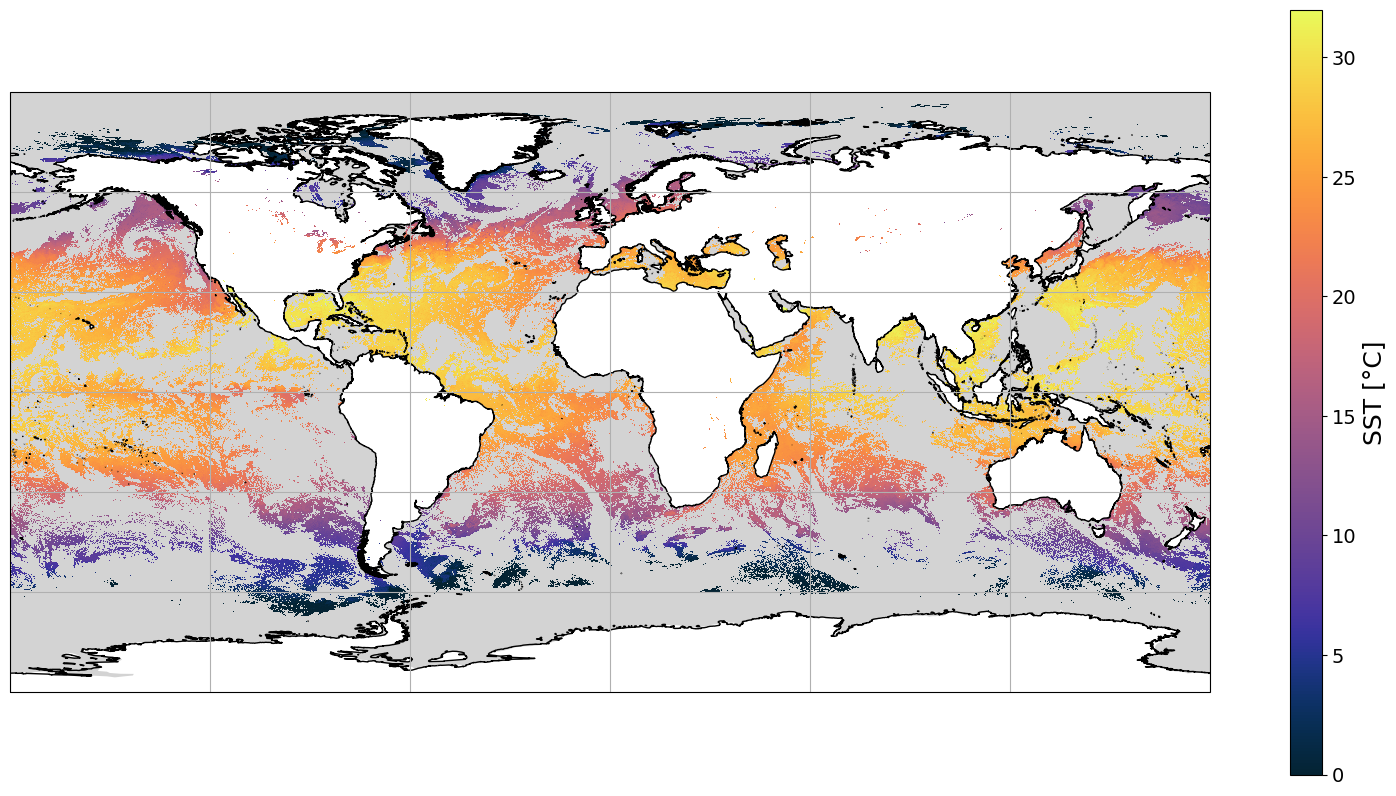

In [4]:
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightgrey')
ax.gridlines()
ax.coastlines('10m')

# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        sst = nc.variables['sea_surface_temperature'][:]
        ql  = nc.variables['quality_level'][:]
        nc.close()
        
        # Use only SST with quality_level > 2
        sst_ql345 = np.ma.masked_where(ql<3, sst)
        
        # plotting sst
        im = plt.pcolormesh(lon, lat, sst_ql345[0,:,:]-273.15, transform=data_projection, cmap=cmap)
        
        # set the min and max temperature for apropriate visualisation
        im.set_clim(0,32)

# Adding a colorbar       
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('SST [°C]', fontsize=18)
cb.ax.tick_params(labelsize=14)
projection=ccrs.Orthographic(0,0)

Try a different projection.

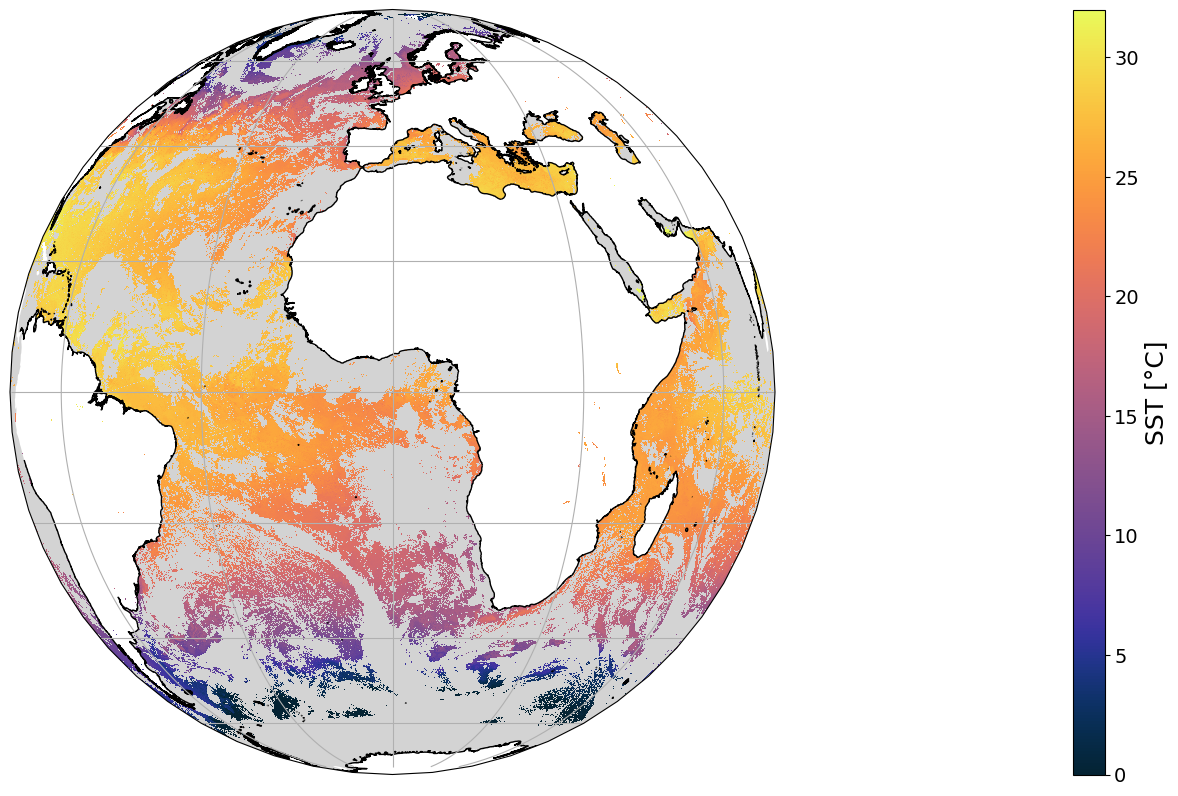

In [5]:
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.Orthographic(0,0)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightgrey')
ax.gridlines()
ax.coastlines('10m')

# open and plot data
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(directory + '/' + filename)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        sst = nc.variables['sea_surface_temperature'][:]
        ql  = nc.variables['quality_level'][:]
        nc.close()
        
        # Use only SST with quality_level > 2
        sst_ql345 = np.ma.masked_where(ql<3, sst)
        
        # plotting sst
        im = plt.pcolormesh(lon, lat, sst_ql345[0,:,:]-273.15, transform=data_projection, cmap=cmap)
        
        # set the min and max temperature for apropriate visualisation
        im.set_clim(0,32)

# Adding a colorbar       
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('SST [°C]', fontsize=18)
cb.ax.tick_params(labelsize=14)

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3a_OSI_SAF_SST_mapping_Metop_Metagranules.ipynb" target="_blank"><< Mapping Metop SST Metagranules</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3c_OSI_SAF_SST_mapping_MSG_SST.ipynb" target="_blank">Mapping Meteosat SEVIRI SST >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>